# Random number generators

Do you know what actually happens when you call function for generating random numbers, e.g. ```np.random.rand()```?

What is a source of randomness in you computer?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

If we look under the hood of any standard generator we will observe nothing but a **fully deterministic algorithm**. All it can do is to produce a **fully deterministic sequence** of numbers. Anytime, anywhere, at any device you will obtain absolutely the same sequence. That is why they are called pseudorandom number generators.

**Never use standard random generators in cryptographic applications!**

For "true" generators based on natural sources of randomness see e.g. https://www.random.org/.

## Methods for generating uniform random numbers

You can browse a lot of methods  for generating random numbers [here](https://en.wikipedia.org/wiki/List_of_random_number_generators). We consider the most common one which is a Linear congruential generator (LCG). When you call ```rand()``` in C/C++, you actually call LCG.

Linear congruential generator produces the following sequence:
$$ z_{i+1} = (az_i + c) \mod m $$

The number $z_0$ is called the *seed*, and setting it allows us to have a reproducible sequence of “random” numbers. The LCG is typically coded to return $z/m$, a floating point number in (0, 1). Obviosuly, this can be easily scaled to any other range $(a,b)$.

Let's implement some LCG:

In [1]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Check the sequence it produces:

In [2]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

One should carefully choose constants $m$, $a$ and $c$. Things can easily go bad if they are choosen "at random":

In [3]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Distribution of the points also mimics uniform distribution

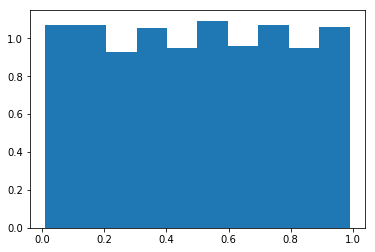

In [4]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

However, spectral test shows that points are bunched up on five lines

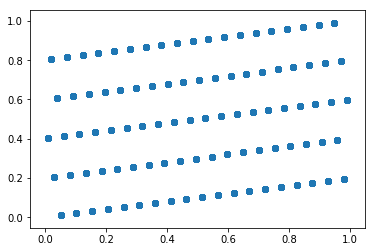

In [5]:
plt.scatter(random[1:], random[:-1])
plt.show()

Appropriate constants produce more "random" scatter

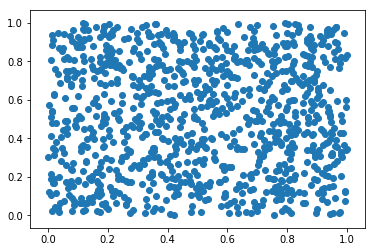

In [6]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

There is a number of tests that check how good random generator works. See [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests) for example.

## Sampling from distributions

Okay, let's suppose we have some generator for uniform random numbers in (0, 1). How we can sample from arbitrary distribution $F$?

### Inverse transform method

Next proposition gives an idea of the *inverse transform method*.

Proove that if $\xi$ is uniform in $[0,1]$ then $F^{-1}(\xi)$ is $F$-distributed. For which $F$ does it hold?

### Exercise
Sample 1000 random numbers from $Exp(\lambda)$ distribution using the inverse transform method. Plot the histogram and the true probability density function (PDF).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import factorial

In [8]:
def F_1(x, l):
    p = np.exp(-l)
    k = 0
    a = 0
    while(a < x):
        k += 1
        a += p
        p *= (l / k)
    return k-1
def F(k, l):
    return np.sum([np.exp(-l) * (l ** i) / factorial(i) for i in range(k+1)])

noise = np.array([np.random.rand() for k in range(10000)])
dist = [F_1(x, 2) for x in noise]
dist = np.array([F(x, 2) for x in dist])
err = np.max(np.abs(noise - dist))
print(err)

0.270487365321


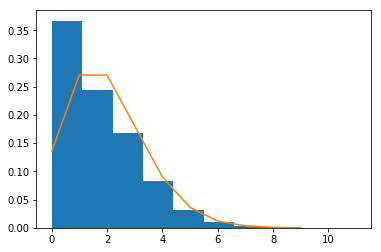

In [9]:
arr = [F_1(np.random.rand(), 2) for k in range(10000)]
plt.hist(arr, normed=True)
plt.plot([np.exp(-2) * (2 ** i) / factorial(i) for i in range(10)])
plt.show()

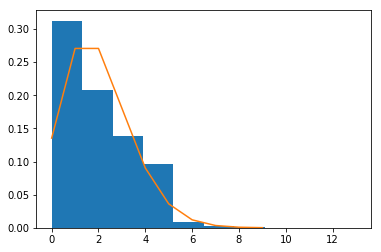

In [10]:
arr = [F_1(np.random.rand(), 2) for k in range(100000)]
plt.hist(arr, normed=True)
plt.plot([np.exp(-2) * (2 ** i) / factorial(i) for i in range(10)])
plt.show()

## Rejection sampling (Accept-reject method)

Next figure shows an idea:
![img](https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png)
We sample points from proposal PDF (which is known and is easy to sample from) and discard points that are above the target PDF. 

### Exercise
Proove that the accept-reject method is valid. Sample 100 points from truncated cauchy distribution given below using uniform random number generator and the accept-reject method. Plot obtained histogram and the true pdf.

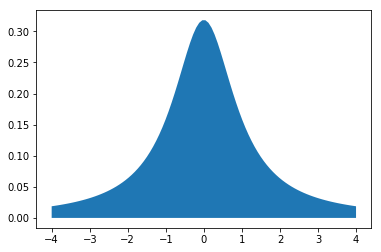

In [12]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

In [35]:
def sample(pdf, n=1, a=-10, b=10):
    arr = []
    while(len(arr) < n):
        p_x = np.random.rand()
        x = (b - a) * np.random.rand() + a
        if p_x < pdf(x):
            arr.append(x)
    return arr
np.linspace(-10,10, 21)

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

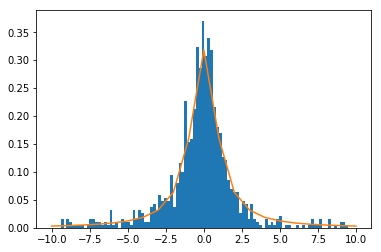

In [50]:
plt.hist(sample(dist.pdf, 1000), bins=100, normed=True)
p = np.array(list(zip(dist.pdf(np.linspace(-10, 10, 21)), np.linspace(-10, 10, 21))))
plt.plot(p[:,1], p[:,0])
plt.show()

Accept-reject method allows to sample from any areas and volumes. However, it may be very inefficient. Sometimes it is possible to find coordinate transformation that maps given region to simple one which is easy to sample from (e.g. unit square).

##  Coordinate transformation

### Exercise
Sample 100 point uniformly distributed inside the triangle given below. To do this, find an appropriate transformation from a unit square and sample from it. Check that you have no rejected points. Plot sampled points.

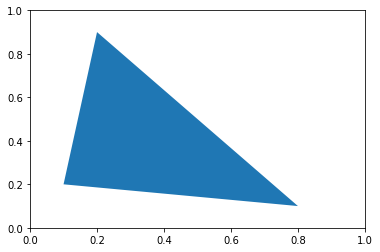

In [52]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

In [59]:
def sample_from_polygon(poly):
    while(1):
        x = np.random.rand()
        y = np.random.rand()
        if poly.contains_point((x, y)):
            yield (x, y)

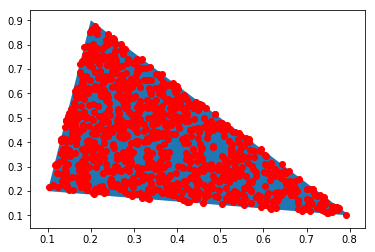

In [67]:
polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
arr = []
gen = sample_from_polygon(polygon)
arr = [next(iter(gen)) for i in range(1000)]
arr = np.array(arr)
plt.scatter(arr[:, 0], arr[:,1], c='r')
plt.show()

### Exercise
Sample 100 point uniformly distributed inside the unit circle. Check that your method does not produce any rejected points. Plot sampled points.

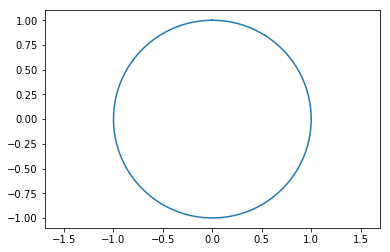

In [12]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

In [72]:
def sample_from_circle():
    while(1):
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1
        if x**2 + y**2 <= 1:
            yield (x, y)

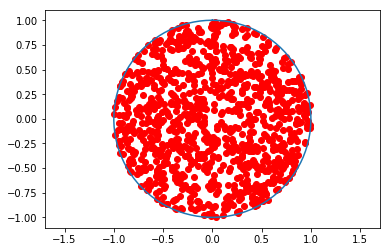

In [74]:
arr = []
gen = sample_from_circle()
arr = [next(iter(gen)) for i in range(1000)]
arr = np.array(arr)
plt.scatter(arr[:, 0], arr[:,1], c='r')
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

In [75]:
def sample_on_circle():
    while(1):
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1
        r = np.sqrt(x**2 + y**2)
        yield (x/r, y/r)

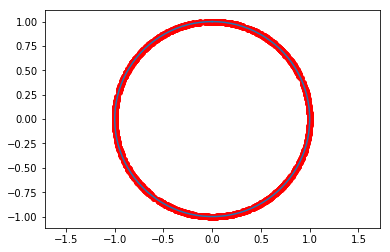

In [76]:
arr = []
gen = sample_on_circle()
arr = [next(iter(gen)) for i in range(1000)]
arr = np.array(arr)
plt.scatter(arr[:, 0], arr[:,1], c='r')
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

## Random normal generator

### Exercise
Check theoretically and numerically that the following algorithm (also called Box-Muller algorithm) generates pairs of intependent N(0,1) variables. Modify it to exclude ```np.sin``` and ```np.cos``` calls.

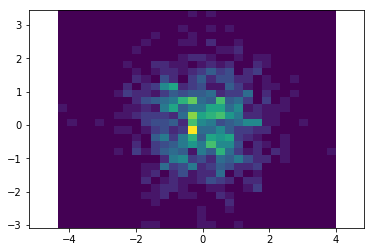

In [79]:
gen = sample_on_circle()
n = 1000
u1 = np.random.rand(n)
r = np.sqrt(-2 * np.log(u1))
p = np.array([next(iter(gen)) for i in range(n)])
x = r * p[:,0]
y = r * p[:,1]
plt.hist2d(x, y, bins=30)
plt.axis('equal')
plt.show()

In [15]:
# Solution here